# Linear Regression in PyTorch

This exercise takes you through the fundamental linear regression model from a number of different angles. First we consider an analytic analysis and then we continue to consider how to solve the same problem using numerical methods. This lab also serves and an introduction to the pytorch toolkit which will be useful for a variety of machine learning tasks in the future and is used by Google to solve massive machine learning problems on their clusters.

The linear regression model forms the basis for a whole host of models - if you are comfortable with the fundamental approaches we take here, there will be a whole range of extensions, advances and applications available to you in the future.

For this lab exercise there are 6 places where you are expected to enter your own code. Every place you have to add code is indicated by

`# Add your code here ..`

`# ***********************************************************`

with instructions above the code block.

In [ ]:
%matplotlib inline
import numpy as np

try:
    in_colab = False
    import google.colab
    in_colab = True
except:
    pass

# Use the following to access torch and tensorboard when running on colab
if in_colab:
    !pip install -U torch

# New for today! Import PyTorch (refered to by package name torch)
import torch

from sklearn import datasets as ds

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 681.6 kB/s eta 0:00:00
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [68]:
# Load the diabetes dataset
x_raw, y_raw = ds.load_diabetes(return_X_y=True)

# Use only one feature (S5 LTG)
x_raw = x_raw[:, 8]

## Diabetes dataset

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

 - Number of Instances: 442

 - Number of Attributes: First 10 columns are numeric predictive values

 - Target: Column 11 is a quantitative measure of disease progression one year after baseline

 - Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499.
(https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)


## Preparing the data

We are going to look at the relationship between the "average number of rooms per dwelling" and median house price in the Boston dataset. First let us partition the data into a training and test split. We are going for 60% training and 40% testing.

In [69]:
total_count = x_raw.shape[0]

split = int(total_count * 0.6)

# Shuffle the data to avoid any ordering bias..
np.random.seed(0)
shuffle = np.random.permutation(total_count)

x = x_raw[shuffle]
y = y_raw[shuffle]

x_train_unnormalised = x[:split]
y_train_unnormalised = y[:split]

x_test_unnormalised = x[split:]
y_test_unnormalised = y[split:]

print('Training set size:', x_train_unnormalised.shape[0])
print('Test set size:', x_test_unnormalised.shape[0])

Training set size: 265
Test set size: 177


## Data Visualisation

To allow for easy visualisation as you progress through the task we are using a single dimensional data set. Both the input $x$ and output $y$ are scalars so we can plot them on a standard scatter plot.

Text(0.5, 1.0, 'Plot of the Training Data')

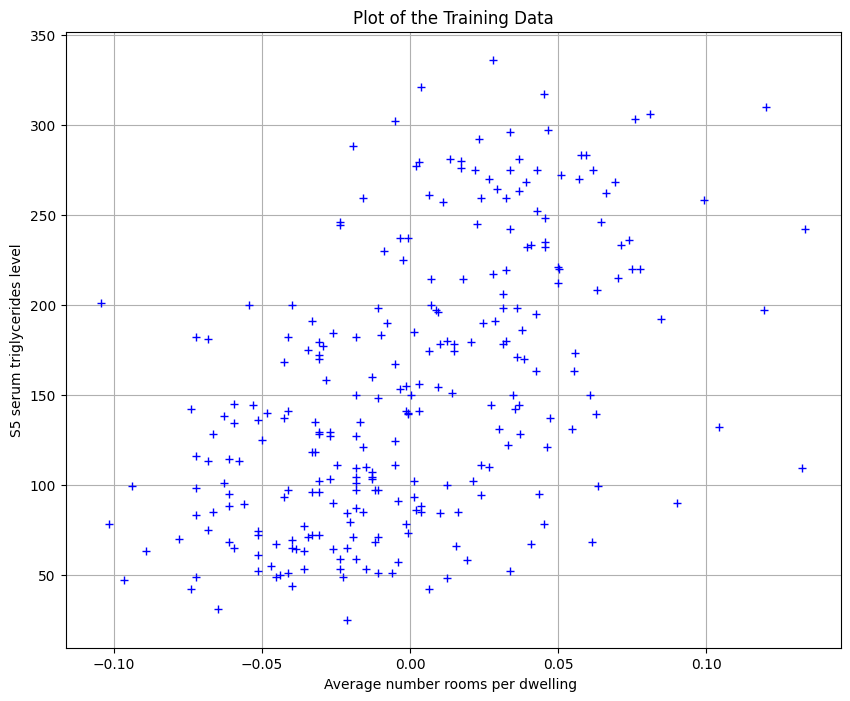

In [70]:
# You can use this function to plot the data and then add your own plots on top..
def plot_data(x, y):
    plt.figure(figsize=[10,8])
    plt.plot(x, y, 'b+')
    plt.grid(True)
    plt.xlabel('Average number rooms per dwelling ')
    plt.ylabel('S5 serum triglycerides level')

plot_data(x_train_unnormalised, y_train_unnormalised)
plt.title('Plot of the Training Data')

### Task 1:

Write a function that normalises a vector of values. It should output a corresponding vector where the values have a mean of zero and a standard deviation of 1. Note that you should only perform an affine transformation of the data (i.e. a linear scaling and a fixed offset). This means that you must find $a$ and $b$ for $v_i = a u_i + b$ where $u$ is the input data and $v$ is the normalised output data.

Your function should return the normalising constants as well as the normalised data.

Write a second function that removes the normalisation and returns the data to its original values.

Check that passing both `x_train` and `y_train` through both functions returns the vectors to their original values.

*Hints:*
- You might want to look at `np.all()` for the Boolean check that they return to their values.
- When checking that floating point values are equal up to nummerical precision (e.g. rounding errors in the computations) you can use the `np.isclose()` function.
- You can use the `assert()` command to guarantee that a statement is `True` before the program continues.

*Points to consider:*
- Why might it be sensible to normalise the data in the fashion described?
- Considering that we are about to perform Linear Regression, why might we not want to perform a more involved normalisation process?

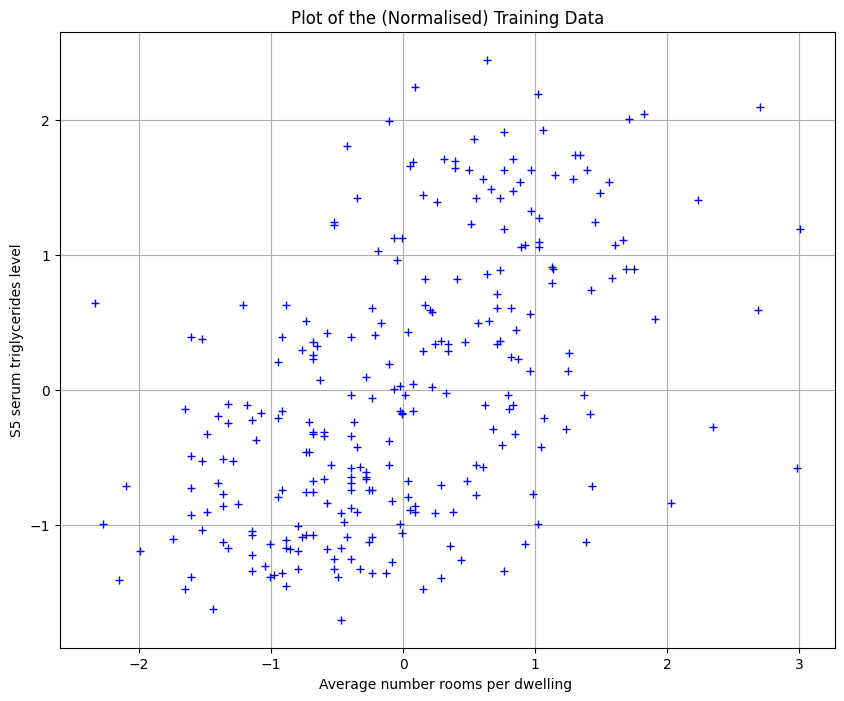

265
177


In [71]:
import numpy as np

def normalise_data(x_unnormalised):
    mean = np.mean(x_unnormalised)
    std = np.std(x_unnormalised)

    x_normalised = (x_unnormalised - mean) / std

    return x_normalised, mean, std

def unnormalise_data(x_normalised, mean, std):
    x_unnormalised = x_normalised * std + mean

    return x_unnormalised




x_train, x_norm_a, x_norm_b = normalise_data(x_train_unnormalised)
y_train, y_norm_a, y_norm_b = normalise_data(y_train_unnormalised)

x_test, _, _ = normalise_data(x_test_unnormalised)
y_test, _, _ = normalise_data(y_test_unnormalised)

# Add your code here to check that the unnormaliseding the
# training data returns to their original values..
# ************************************************************
# ...

# Assuming x_train_unnormalised and y_train_unnormalised are already defined

# Normalise training data
x_train, x_norm_mean, x_norm_std = normalise_data(x_train_unnormalised)
y_train, y_norm_mean, y_norm_std = normalise_data(y_train_unnormalised)

# Normalise test data using the same mean and std from training data
x_test = (x_test_unnormalised - x_norm_mean) / x_norm_std
y_test = (y_test_unnormalised - y_norm_mean) / y_norm_std

# Check that unnormalising the training data returns to their original values
x_train_restored = unnormalise_data(x_train, x_norm_mean, x_norm_std)
y_train_restored = unnormalise_data(y_train, y_norm_mean, y_norm_std)

# Assertion checks to verify restoration
assert np.all(np.isclose(x_train_restored, x_train_unnormalised))
assert np.all(np.isclose(y_train_restored, y_train_unnormalised))

# Plot the data to verify normalisation
plot_data(x_train, y_train)
plt.title('Plot of the (Normalised) Training Data')
plt.show()
print(len(x_train))
print(len(x_test))


## The Linear Regression Model

In linear regression we are trying to fit a linear model to the data of the form

\begin{align}
y &= w x + c
\end{align}

where $w$ and $c$ are parameters to be learned that take the input data $x$ to the output data $y$. Once this model has been learned, we can use the parameters to predict the values of the output that would correspond to new values of the input.

In order to determine the parameters, we need an objective function that we seek to optimise: this function returns a scalar value for all possible parameter values and we seek to change the parameters until the best scalar value is obtained.

For linear regression, we usually take the objective as one which minimises the squared error; this is known as a linear least squares problem.

*Aside: Think about what this means in terms of a model for the data when you have $y = f(x) + \eta$ with $f(x)$ as a linear function $f(x) = w x + c$ and $\eta$ as iid Gaussian noise.*

Therefore our objective is given by the sum of squared differences between the true value of $y_i$ and the value estimated by our model $w x_i + c$.

\begin{align}
E(w,c) &= \sum_{i=0}^{N-1} \big(y_i - f(x_i) \big)^2 \\
    &= \sum_{i=0}^{N-1} \big(y_i - (w x_i + c) \big)^2 \\
    &= \sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2
\end{align}



## Task 2

Write a function that calculates the least squared error on the training data for a particular value of the parameters $w$ and $c$.

In [72]:
def least_squares_error(x, y, w, c):
    # Calculate predicted values
    y_pred = w * x + c

    # Calculate squared errors
    squared_errors = (y_pred - y) ** 2

    # Sum of squared errors
    squared_error = np.sum(squared_errors)

    return squared_error
# Example usage
print('Squared error for w = 1.5, c = 0.5 is ',
      least_squares_error(x_train, y_train, w=1.5, c=0.5))

print(len(x_train))
print(len(x_test))

Squared error for w = 1.5, c = 0.5 is  515.5000907649276
265
177


## Analytic Solution

In the case of linear regression, we can find an analytic solution to this problem by finding stationary point of the objective function. We do this by evaluating the partial derivatives of the objective wrt each parameter in turn and setting them to zero. If we can then find a solution to these simultaneous equations, we have found an optimal setting for the parameters.

For $w$ we have:

\begin{align}
\frac{\partial E}{\partial w}
    &= \frac{\partial}{\partial w}\sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} \frac{\partial}{\partial w} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \frac{\partial}{\partial w} \big(y_i - w x_i - c \big) \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \big(- x_i \big) \\
    &= \sum_{i=0}^{N-1} 2 x_i (w x_i + c - y_i) \\
\end{align}

For $c$ we have:

\begin{align}
\frac{\partial E}{\partial c}
    &= \frac{\partial}{\partial c}\sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} \frac{\partial}{\partial c} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \frac{\partial}{\partial c} \big(y_i - w x_i - c \big) \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \big(- 1 \big) \\
    &= \sum_{i=0}^{N-1} 2 (w x_i + c - y_i) \\
\end{align}

Now setting $\frac{\partial E}{\partial w} = 0$:

\begin{align}
\Rightarrow \sum_{i=0}^{N-1} x_i (w x_i + c - y_i) &= 0 \\
w \sum_{i=0}^{N-1} (x_i)^2 + c \sum_{i=0}^{N-1} (x_i) - \sum_{i=0}^{N-1} (x_i y_i) &= 0 \\
\Rightarrow A w + B c - C &= 0
\end{align}

with $A = \sum_{i=0}^{N-1} (x_i)^2$, $B = \sum_{i=0}^{N-1} (x_i)$ and $C = \sum_{i=0}^{N-1} (x_i y_i)$.

Now setting $\frac{\partial E}{\partial c} = 0$:

\begin{align}
\Rightarrow \sum_{i=0}^{N-1} (w x_i + c - y_i) &= 0 \\
w \sum_{i=0}^{N-1} (x_i) + N c - \sum_{i=0}^{N-1} (y_i) &= 0 \\
\Rightarrow B w + N c - D &= 0
\end{align}

with $D = \sum_{i=0}^{N-1} (y_i)$.

Combining these two:

\begin{align}
\Rightarrow c = \frac{1}{N} (D - B w) \\
\Rightarrow A w + \frac{B}{N} (D - B w) - C = 0 \\
\Rightarrow w \left(A - \frac{B^2}{N}\right) = \left(C - \frac{BD}{N}\right) \\
\Rightarrow w = \frac{CN - BD}{AN - B^2} \\
\Rightarrow c = \frac{1}{N} \left(D - B \frac{\left(CN - BD\right)}{\left(AN - B^2\right)}\right) \\
\Rightarrow c = \frac{1}{N} \left(\frac{D \left(AN - B^2\right) - B C N + B^2 D}{\left(AN - B^2\right)}\right) \\
\Rightarrow c = \frac{AD - BC}{AN - B^2}
\end{align}

## Task 3

Write a function using numpy that takes as input `x_train` and `y_train` and outputs the optimal $w$ and $c$ parameters for least squares linear regression.

Confirm that your results are reasonable by plotting the resulting linear function on the training graph as well as the predicted values for the test set on a separate graph.

265
177
Analytic solution:
Analytic w =  0.5182388795409717
Analytic c =  -1.3034627204927576e-16


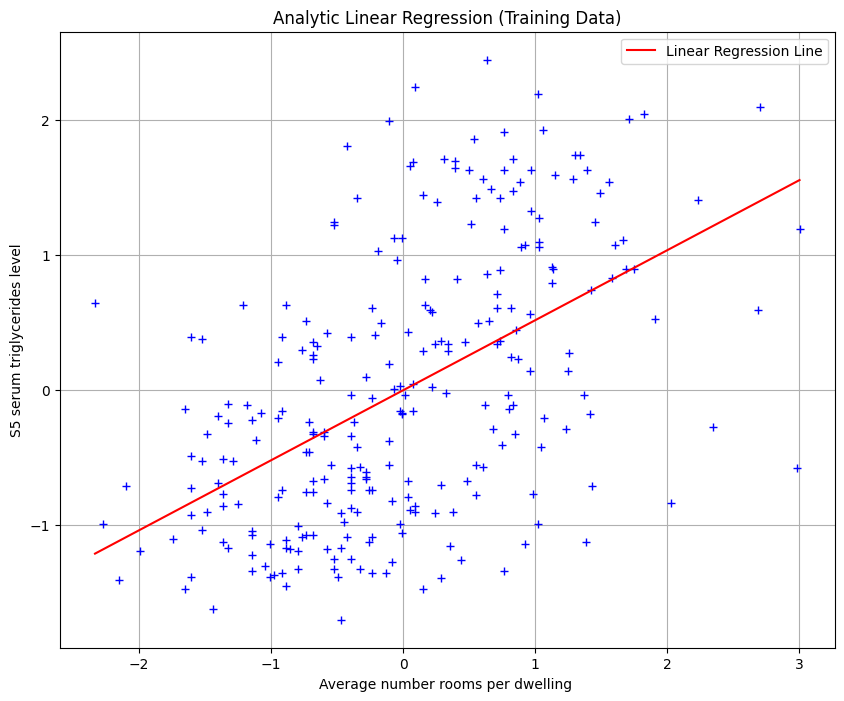

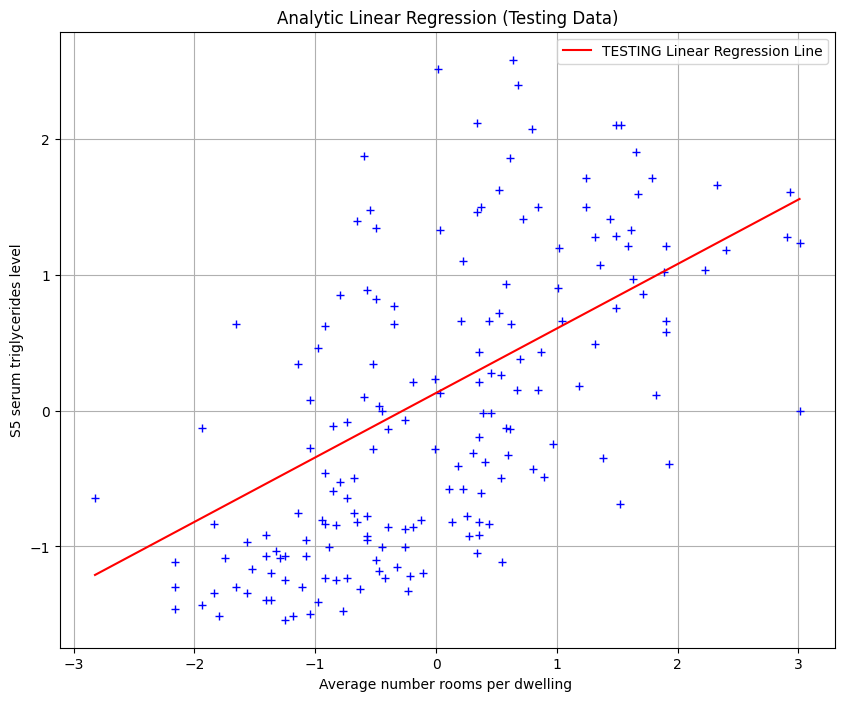

Mean least squares error on TRAINING data =  0.731428463732118
Mean least squares error on TEST data =  0.6977028338729457
265
177


In [73]:
def least_squares_analytic_solution(x, y):
    # Add code to calcuate the optimal w and c ..
    # ************************************************************
    # ...
    N = len(x)
    A = np.sum(x ** 2)
    B = np.sum(x)
    C = np.sum(x * y)
    D = np.sum(y)

    # Calculate optimal parameters w and c
    w = (C * N - B * D) / (A * N - B ** 2)
    c = (D * A - B * C) / (A * N - B ** 2)

    return w, c

w_opt, c_opt = least_squares_analytic_solution(x_train, y_train)

print(len(x_train))
print(len(x_test))
print('Analytic solution:')
print('Analytic w = ', w_opt)
print('Analytic c = ', c_opt)

plot_data(x_train, y_train)
plt.title('Analytic Linear Regression (Training Data)')
# Add code to plot a line showing your solution
# for w and c..
# ************************************************************
# ...
# Plot the linear regression line
x_line = np.linspace(np.min(x_train), np.max(x_train), 100)
y_line = w_opt * x_line + c_opt
plt.plot(x_line, y_line, 'r-', label='Linear Regression Line')
plt.legend()
plt.show()


plot_data(x_test, y_test)
plt.title('Analytic Linear Regression (Testing Data)')
# Add code to plot your predictions for the x_test data
# for comparison against y_test..
# ************************************************************
# ...
x_line2 = np.linspace(np.min(x_test), np.max(x_test), 100)
y_line2 = w_opt * x_line + c_opt
plt.plot(x_line2, y_line2, 'r-', label='TESTING Linear Regression Line')
plt.legend()
plt.show()


print('Mean least squares error on TRAINING data = ',
     least_squares_error(x_train, y_train, w_opt, c_opt) / x_train.shape[0])

print('Mean least squares error on TEST data = ',
     least_squares_error(x_test, y_test, w_opt, c_opt) / x_test.shape[0])

print(len(x_train))
print(len(x_test))


## PyTorch Optimisation

**For help with this please refer to the separate pytorch example that was worked through in class and is available on moodle as a separate jupyter notebook. Please load the example notebook and run through it yourself again before continuing with this task.**

In the previous task we looked at an analytic solution to the least square problem. We now pretend that we could not solve the problem analytically. Although this is not true for this case, the additional of extensions to the linear regression model (for example to improve robustness, adding feature selection or handling non-linear data) can mean that it is no longer possible to find an analytic solution and numerical optimisation must be used.

## Task 4

Add the torch expressions to the following code to calculate the least squares error using torch and check that it calculates the same value as the numpy version.


In [74]:
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Constants to hold the training data..
t_x_train = torch.tensor(x_train)
t_y_train = torch.tensor(y_train)

# Variables to hold w and c
t_w = torch.tensor(w_initial_guess, dtype=torch.float64, requires_grad=True)

t_c = torch.tensor(c_initial_guess, dtype=torch.float64, requires_grad=True)


def calculate_least_squares_error_torch(t_x_train, t_y_train, t_w, t_c):

    # Add your code here to calculate t_least_squares_error..
    # ************************************************************
    # ...

    # Calculate the predicted values
    t_y_pred = t_w * t_x_train + t_c

    # Calculate the squared error
    t_squared_error = torch.sum((t_y_pred - t_y_train)**2)

    return t_squared_error

t_least_squares_error = calculate_least_squares_error_torch(t_x_train, t_y_train, t_w, t_c)

# Check with the result from your previous function..
numpy_result = least_squares_error(x_train, y_train, w=w_initial_guess, c=c_initial_guess)

print('Torch least squares error = ', t_least_squares_error)
print('numpy least squares error = ', numpy_result)

# This should pass if they are the same to nummerical precision!
assert(np.isclose(t_least_squares_error.item(), numpy_result))

print('Assertion passed - same result to nummerical precision!')




Torch least squares error =  tensor(515.5001, dtype=torch.float64, grad_fn=<SumBackward0>)
numpy least squares error =  515.5000907649276
Assertion passed - same result to nummerical precision!


## Task 5

Check that the gradients from torch are correct by writing numpy code to calculate the value of the derivatives from the analytic expressions (derived previously):

\begin{align}
\frac{\partial E}{\partial w}
    &= \sum_{i=0}^{N-1} 2 x_i (w x_i + c - y_i) \\
\end{align}

\begin{align}
\frac{\partial E}{\partial c}
    &= \sum_{i=0}^{N-1} 2 (w x_i + c - y_i) \\
\end{align}

In [77]:
# Clear and gradient data and run the backwards pass to calculate the
# gradients in pytorch (as in the pytorch example notebook)
if t_w.grad is not None:
    t_w.grad.data.zero_()
if t_c.grad is not None:
    t_c.grad.data.zero_()

# Note: In this instance we use retain_graph for the purposes of debugging
# (i.e. we might use the backward pass multiple times)
t_least_squares_error.backward(retain_graph=True)

print('Torch gradient wrt w=  ', t_w.grad)
print('Torch gradient wrt c = ', t_c.grad)

def calc_gradients_for_least_squares(x, y, w, c):
    # Add your code to evalute the partial derivatives here
    # ************************************************************
    # ...
    grad_w = np.sum(2 * x * (w * x + c - y))
    grad_c = np.sum(2 * (w * x + c - y))


    return grad_w, grad_c

numpy_grad_w, numpy_grad_c = calc_gradients_for_least_squares(x_train, y_train, w_initial_guess, c_initial_guess)

print('Analytic gradient wrt w = ', numpy_grad_w)
print('Analytic gradient wrt c = ', numpy_grad_c)

# This should pass if they are the same to nummerical precision!
assert(np.isclose(t_w.grad.item(), numpy_grad_w))
assert(np.isclose(t_c.grad.item(), numpy_grad_c))

print('Assertion passed - same result to nummerical precision!')

Torch gradient wrt w=   tensor(520.3334, dtype=torch.float64)
Torch gradient wrt c =  tensor(265.0000, dtype=torch.float64)
Analytic gradient wrt w =  520.3333938432851
Analytic gradient wrt c =  265.00000000000006
Assertion passed - same result to nummerical precision!


## Gradient Descent in PyTorch

If all has gone well, the gradients should be the same and you can use torch to find the solution to the optimisation.

**Run the following block of code to see the torch optimisation running with your least square error function from above!**

*Aside: Investigate what happens as you change the `learning_rate` parameter as well as the `num_iterations`. Can we guarantee that torch will always return the same result as the analytic solution? What might be happening if not?*

In [1]:
# Create a gradient descent optimiser that uses a
# certain step size (learning_rate)..
learning_rate = 1.0e-3

# Variables to hold w and c, initialised appropriately
t_w = torch.tensor(w_initial_guess,
                  dtype=torch.float64,
                  requires_grad=True)
t_c = torch.tensor(c_initial_guess,
                  dtype=torch.float64,
                  requires_grad=True)

# We want to optimise wrt w and c
vars_to_optimise = [t_w, t_c]

optimizer = torch.optim.SGD(params=vars_to_optimise, lr=learning_rate)

# Number of iterations to perform
num_iterations = 15

for iteration in range(num_iterations + 1):
    # Perform the forward pass, calculate the error..
    t_objective = calculate_least_squares_error_torch(t_x_train,
                                                      t_y_train,
                                                      t_w,
                                                      t_c)

    # Clear the gradients..
    optimizer.zero_grad()

    # Perform the backwards pass to calculate the gradients..
    t_objective.backward()

    # Update the parameters via the optimiser..
    optimizer.step()

    # Print out the current values
    print('iter %4d, E(w,c) = %0.3f' %
                (iteration + 1, t_objective.item()))

print('\nAfter torch optimisation:')
print('Torch w = ', t_w)
print('Torch c = ', t_c)

print('\nAnalytic solution:')
print('Analytic w = ', w_opt)
print('Analytic c = ', c_opt)

NameError: name 'torch' is not defined

## Task 6

You are now going to implement your own version of gradient descent (the process that torch is providing to perform optimisation). The good news is that you already have the numpy functions to calculate both the least squares error (`least_squares_error`) and the gradients wrt the parameters (`calc_gradients_for_least_squares`).

Starting from the same initial values as torch (`w_initial_guess`, `c_initial_guess`) write an iterative algorithm for gradient descent. At each iteration it should perform the following steps:

- Evaluate and save the squared error for the current parameters
- Calculate the gradients wrt w and c for the current parameters
- Update the parameters for w and c my moving in the direction of the negative current proportional to the current step size

**The code below should run with these three additions. Once they are working, move on to the following.**

Under this algorithm, the squared error should decrease at each iteration. If it is not decreasing then either there is a bug in the code (!) or the step size is too large. Add a check that makes sure the squared error always decreases and if it fails to decrease, decrease the step size and run the iteration again.

**Try running this code starting with `current_step_size = 0.1`.**

You can improve your answer by checking to see if you should stop iterating. If the change in the squared error between successive iterations is very small then one of the following is true. Either the step size is too small (not changing the parameters sufficiently) or the values have converged to their optimal values. If you cannot find a step size that creates a deacrease in the squared error then you have probably converged and can stop performing iterations.

*Hint: you can exit a `for` loop early with the `break` command.*

**Try running this code starting with `num_iterations = 200`.**

In [ ]:
# Keep track of parameter values over iterations..
w_current = w_initial_guess
c_current = c_initial_guess

# Keep track of the error..
E_current = least_squares_error(x_train, y_train, w_current, c_current)

# Keep track of the step size..
current_step_size = 0.1

num_iterations = 200

converge_threshold = 1e-13

for iteration in range(num_iterations):

    # Add code to evaluate the gradients..
    # ************************************************************
    # ...



    # Add code to take a step in the direction of the negative
    # gradient proportional to the step size..
    # ************************************************************
    # ...

    w_new =
    c_new =

    # Add code to evaluate and remember the squared error..
    # ************************************************************
    # ...

    E_new =

    # Add code to check that error is decreasing and reduce step
    # size if not..
    # ************************************************************
    # ...



    # Add code to check for convergence and terminate
    # the loop if converged..
    # ************************************************************
    # ...



    print('iteration %4d, E = %f, w = %f, c = %f' %
      (iteration, E_new, w_new, c_new))

    if converged:
        print('Converged!')
        break

    # Take the step
    w_current = w_new
    c_current = c_new
    E_current = E_new

print('\nAfter gradient descent optimisation:')
print('Optimised w = ', w_current)
print('Optimised c = ', c_current)

print('\nAnalytic solution:')
print('Analytic w = ', w_opt)
print('Analytic c = ', c_opt)

## Additional Task: Create a PyTorch Module

We can create a custom module for our model so that we can train using a standard pytorch workflow (as in the pytorch example notebook).



In [ ]:
# Create a gradient descent optimiser that uses a
# certain step size (learning_rate)..
learning_rate = 1.0e-3

# Create our own class derived from the torch module..
class LinearRegressionModel(torch.nn.Module):
    # We must initialise our model - we specify our initial guesses for the
    # parameters..
    def __init__(self, w_initial_guess, c_initial_guess):
        # Call the constructor for the torch.nn.Module super class..
        super().__init__()

        # We use the Parameter class (rather than tensors) for the module
        # but these behave in the same way..
        self.t_w = torch.nn.Parameter(torch.tensor(w_initial_guess))
        self.t_c = torch.nn.Parameter(torch.tensor(c_initial_guess))

    # This defines the forward operation on some data passed in
    def forward(self, t_x_train, t_y_train):
        # Calculate the error using our function defined above and the
        # data passed in. Remember to use the parameters from the class..
        t_objective = calculate_least_squares_error_torch(t_x_train,
                                                          t_y_train,
                                                          self.t_w,
                                                          self.t_c)

        return t_objective

# Create our model - it will initialise the paramters appropriately
linear_regression_model = LinearRegressionModel(w_initial_guess, c_initial_guess)
# Put the model in training mode..
linear_regression_model.train()

optimizer = torch.optim.SGD(params=linear_regression_model.parameters(),
                            lr=learning_rate)

# Number of iterations to perform
num_iterations = 15

for iteration in range(num_iterations + 1):
    # Perform the forward pass, calculate the error on the specified data..
    t_objective = linear_regression_model(t_x_train, t_y_train)

    # Clear the gradients..
    optimizer.zero_grad()

    # Perform the backwards pass to calculate the gradients..
    t_objective.backward()

    # Update the parameters via the optimiser..
    optimizer.step()

    # Print out the current values
    print('iter %4d, E(w,c) = %0.3f' %
                (iteration + 1, t_objective.item()))

print('\nAfter torch optimisation:')
print('Torch w = ', t_w)
print('Torch c = ', t_c)

print('\nAnalytic solution:')
print('Analytic w = ', w_opt)
print('Analytic c = ', c_opt)

## Further tasks:

- Add a prediction function to the class above so that you can use the trained model to run predictions on new test data - you can use this to plot the output of the model after training.
- Load up a different source of data to test your model on.
- Add minibatching to allow you to run each iteration on a subset of the data.
- Produce a new custom module that implements a fully connected neural network (or MLP) to produce predictions on your new dataset. You can run through the torch [neural networks tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html).